In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import argparse
import torch
import json
from collections import defaultdict

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

from diffmask.models.sentiment_classification_sst_diffmask import (
    BertSentimentClassificationSSTDiffMask,
    RecurrentSentimentClassificationSSTDiffMask,
    PerSampleDiffMaskRecurrentSentimentClassificationSSTDiffMask,
    PerSampleREINFORCERecurrentSentimentClassificationSSTDiffMask,
)
from diffmask.utils.plot import plot_sst_attributions

In [3]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--gpu", type=str, default="0")
    parser.add_argument("--model", type=str, default="bert-base-uncased")
    parser.add_argument("--train_filename", type=str, default="./datasets/sst/train.txt")
    parser.add_argument("--val_filename", type=str, default="./datasets/sst/dev.txt")
    parser.add_argument("--batch_size", type=int, default=64)
    parser.add_argument("--gate_bias", action="store_true")
    parser.add_argument("--seed", type=float, default=0)
    parser.add_argument("--architecture", type=str, default="bert", choices=["gru", "bert"])
    parser.add_argument(
        "--model_path",
        type=str,
        default="models/sst-diffmask-hidden.ckpt",
#         or
#         default="models/sst-diffmask-input.ckpt",
    )
    
    hparams, _ = parser.parse_known_args()
    
    torch.manual_seed(hparams.seed)
    
    os.environ["CUDA_VISIBLE_DEVICES"] = hparams.gpu

# Loading a model

In [4]:
device = "cuda:0"

if hparams.architecture == "bert":
    model = BertSentimentClassificationSSTDiffMask.load_from_checkpoint(hparams.model_path).to(device)
elif hparams.architecture == "gru":
    if "per_sample-diffmask" in hparams.model_path:
        model = PerSampleDiffMaskRecurrentSentimentClassificationSSTDiffMask.load_from_checkpoint(
            hparams.model_path
        ).to(device)
    elif "per_sample-reinforce" in hparams.model_path:
        model = PerSampleREINFORCERecurrentSentimentClassificationSSTDiffMask.load_from_checkpoint(
            hparams.model_path
        ).to(device)
    else:
        model = RecurrentSentimentClassificationSSTDiffMask.load_from_checkpoint(
            hparams.model_path
        ).to(device)

model.freeze()

# Creating and plotting DiffMask attributions

In [5]:
source = "A fast , funny , highly enjoyable movie ."

inputs_dict = {
    k: v.to(device)
    for k, v in model.tokenizer.encode_plus(
        source,
        max_length=384,
        pad_to_max_length=True,
        return_tensors="pt",
    ).items()
}
inputs_dict["mask"] = inputs_dict["attention_mask"]
del inputs_dict["attention_mask"]
del inputs_dict["token_type_ids"]

source = model.tokenizer.tokenize(source)
tokens = ["[CLS]"]  + source + ["[SEP]"]

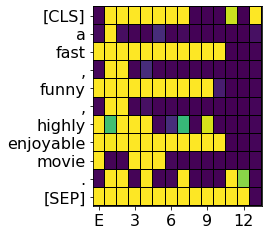

In [6]:
attributions = model.forward_explainer(
    **inputs_dict, attribution=True
).exp()[0,:len(tokens)].cpu()

plot_sst_attributions(attributions, tokens)

# Computing statistics on the validation set

In [7]:
model.prepare_data()

with open("./datasets/sst/dev-mapping.json", "r") as f:
    model.val_dataset_orig = json.load(f)

In [8]:
for i, batch in tqdm(enumerate(model.val_dataloader()), total=len(model.val_dataset) // model.hparams.batch_size):
    input_ids, mask, label = tuple(e.to(device) for e in batch)
    
    attributions = model.forward_explainer(
        input_ids, mask, attribution=True
    ).exp().cpu()

    for j in range(attributions.shape[0]):
        model.val_dataset_orig[i * model.hparams.batch_size + j] += [attributions[j,:mask[j].sum().item()]]

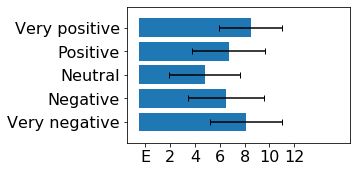

In [9]:
counts = defaultdict(list)
for e in model.val_dataset_orig:
    for k, v in zip(e[-3], e[-1][1:-1].sum(-1)):
        counts[k].append(v)
        
counts = sorted([(k, torch.stack(v)) for k, v in counts.items()])
counts = [(k, (v.mean(), v.std())) for k, v in counts]
counts_label = ["Very negative", "Negative",  "Neutral", "Positive", "Very positive"]

fig = plt.figure(figsize=(4, len(counts) / 2))
plt.barh(range(len(counts)),
        [m.item() for k, (m, s) in counts],
        xerr=[s.item() for k, (m, s) in counts],
        capsize=3)
plt.yticks(torch.arange(len(counts)), [counts_label[k] for k, (m, s) in counts], size=16)
plt.xticks(torch.arange(0, 13, 2) + .5, ["E"] + list(range(2, 13, 2)), size=16)
plt.xlim(-1, 17)
plt.margins(y=.5 / len(counts))

plt.show()

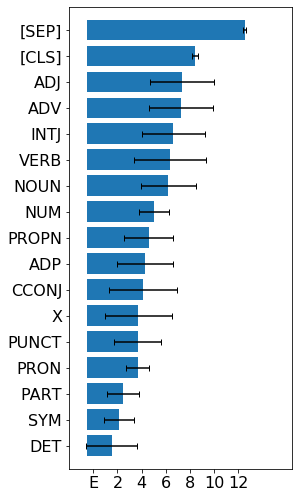

In [10]:
counts = defaultdict(list)
for e in model.val_dataset_orig:
    for k, v in zip([f[0] for f in e[-2]], e[-1][1:-1].sum(-1)):
        counts[k].append(v)
    counts["[CLS]"].append(e[-1][0].sum(-1))
    counts["[SEP]"].append(e[-1][-1].sum(-1))
        
counts = sorted([(k, torch.stack(v)) for k, v in counts.items()])
counts = [(k, (v.mean(), v.std())) for k, v in counts]
counts = sorted(counts, key=lambda x: x[1][0])

fig = plt.figure(figsize=(4, len(counts) / 2))
plt.barh(range(len(counts)),
        [m.item() for k, (m, s) in counts],
        xerr=[s.item() for k, (m, s) in counts],
        capsize=3)
plt.yticks(torch.arange(len(counts)), [k for k, (m, s) in counts], size=16)
plt.xticks(torch.arange(0, 13, 2) + .5, ["E"] + list(range(2, 13, 2)), size=16)
plt.xlim(-1.5, 17)
plt.margins(y=.5 / len(counts))

plt.show()